## Spatial Hot Spots

### Importe und vorbereitende Berechnungen

In [16]:
import re
import folium
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

In [17]:
# Import vom DF
trips_df = pd.read_parquet('../../data/rides/Taxi_Trips_Sampled_Cleaned.parquet')

In [18]:
# Allgemeine Infos zum DF
trips_df.info()
trips_df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170749 entries, 0 to 170748
Data columns (total 40 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   taxi_id                 170749 non-null  int64         
 1   trip_start_timestamp    170749 non-null  datetime64[ns]
 2   trip_end_timestamp      170749 non-null  datetime64[ns]
 3   trip_seconds            170749 non-null  float64       
 4   trip_miles              170749 non-null  float64       
 5   pickup_census_tract     170749 non-null  int64         
 6   dropoff_census_tract    170749 non-null  int64         
 7   pickup_community_area   170749 non-null  int64         
 8   dropoff_community_area  170749 non-null  int64         
 9   fare                    170749 non-null  float64       
 10  tips                    170749 non-null  float64       
 11  tolls                   170749 non-null  float64       
 12  Extras                  170749

,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,...,h3_07_dropoff,h3_08_pickup,h3_08_dropoff,h3_09_pickup,h3_09_dropoff,pickup_centroid,dropoff_centroid,datetime,temp,precip
0,1,2015-01-01 00:00:00,2015-01-01 00:15:00,840.0,2.9,17031241400,17031062800,24,6,9.85,...,872664c12ffffff,882664cac1fffff,882664c129fffff,892664cac03ffff,892664c1293ffff,POINT (-87.675311622 41.906025969),POINT (-87.661265218 41.936159071),2015-01-01,-7.0115,0
1,2,2015-01-01 00:00:00,2015-01-01 00:00:00,480.0,0.9,17031320100,17031081500,32,8,6.25,...,872664c1effffff,882664c1e3fffff,882664c1e1fffff,892664c1e2fffff,892664c1e0fffff,POINT (-87.620992913 41.884987192),POINT (-87.626214906 41.892507781),2015-01-01,-7.0115,0
2,3,2015-01-01 00:00:00,2015-01-01 00:15:00,600.0,2.4,17031071500,17031070700,7,7,8.85,...,872664c12ffffff,882664c115fffff,882664c121fffff,892664c114fffff,892664c1257ffff,POINT (-87.631717366 41.914616286),POINT (-87.673807238 41.929272532),2015-01-01,-7.0115,0
3,4,2015-01-01 00:15:00,2015-01-01 00:15:00,377.0,1.4,17031081700,17031281900,8,28,6.45,...,872664c1affffff,882664c1e7fffff,882664c1adfffff,892664c1e73ffff,892664c1acfffff,POINT (-87.63186395 41.892042136),POINT (-87.642648998 41.879255084),2015-01-01,-7.0115,0
4,5,2015-01-01 00:15:00,2015-01-01 00:30:00,480.0,1.4,17031080300,17031081700,8,8,6.65,...,872664c1effffff,882664c13bfffff,882664c1e7fffff,892664c13afffff,892664c1e73ffff,POINT (-87.63576009 41.90749193),POINT (-87.63186395 41.892042136),2015-01-01,-7.0115,0


In [19]:
# Extrahieren der Längen- und Breitengrade
def extract_coordinates(point):
    coords = re.findall(r"[-+]?\d*\.\d+|\d+", point)
    return [float(coord) for coord in coords]

trips_df['pickup_point'] = trips_df['pickup_centroid'].apply(extract_coordinates)
trips_df['dropoff_point'] = trips_df['dropoff_centroid'].apply(extract_coordinates)

pickup_coordinates = np.vstack(trips_df['pickup_point'].values)
dropoff_coordinates = np.vstack(trips_df['dropoff_point'].values)

### Bestimmung der Hyperparameter
#### Number of clusters

In [20]:
# Ellbogen Methode für pickup und dropoff
n_components = np.arange(1, 10)

# Modelle für pickup
models_pickup = [GaussianMixture(n, covariance_type='full', random_state=0).fit(pickup_coordinates)
                 for n in n_components]
# Modelle für dropoff
models_dropoff = [GaussianMixture(n, covariance_type='full', random_state=0).fit(dropoff_coordinates)
                  for n in n_components]

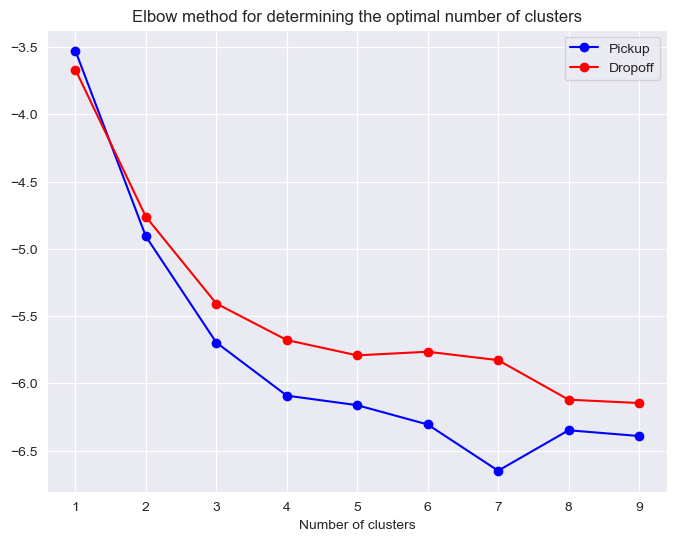

In [21]:
# Erstellen Sie eine einzelne Figur
plt.figure(figsize=(8, 6))

# Zeichnen Sie den Plot für pickup
plt.plot(n_components, [-m.score(pickup_coordinates) for m in models_pickup], color='blue', label='Pickup', marker='o')

# Zeichnen Sie den Plot für dropoff
plt.plot(n_components, [-m.score(dropoff_coordinates) for m in models_dropoff], color='red', label='Dropoff', marker='o')

# Beschriftung und Legende
plt.title('Elbow method for determining the optimal number of clusters')
plt.xlabel('Number of clusters')
plt.legend(loc='best')
plt.show()

### optimal bandwith 

In [22]:
def calculate_best_bandwidth(coordinates, bandwidths_range=(-1, 1, 10), cv=5, n_jobs=-1):
    # Berechnung einer optimalen Bandbreite
    bandwidths = 10 ** np.linspace(*bandwidths_range)

    # Erzeugen Sie ein KernelDensity-Objekt
    kde = KernelDensity()

    # Nutzen Sie GridSearchCV, um die beste Bandbreite zu finden
    # Hier setzen wir n_jobs=-1, um alle verfügbaren Kerne zu nutzen
    grid = GridSearchCV(kde, {'bandwidth': bandwidths}, cv=cv, n_jobs=n_jobs)  # Kreuzvalidierung
    grid.fit(coordinates)

    # Beste Bandbreite
    best_bandwidth = grid.best_params_['bandwidth']

    return best_bandwidth

# Beste Bandbreite für Abholort berechnen
best_bandwidth_pickup = calculate_best_bandwidth(pickup_coordinates)
print("Beste Bandbreite Pickup: ", best_bandwidth_pickup)

# Beste Bandbreite für Absetzort berechnen
best_bandwidth_dropoff = calculate_best_bandwidth(dropoff_coordinates)
print("Beste Bandbreite Dropoff: ", best_bandwidth_dropoff)

Beste Bandbreite Pickup:  0.1
Beste Bandbreite Dropoff:  0.1


#### KDE Bandwith

In [23]:
# Erstellen Sie eine räumliche Kerndichteschätzung
kde_pickup = KernelDensity(kernel='gaussian', bandwidth=best_bandwidth_pickup).fit(pickup_coordinates)
kde_dropoff = KernelDensity(kernel='gaussian', bandwidth=best_bandwidth_dropoff).fit(dropoff_coordinates)

# Berechnen Sie die Dichte-Schätzung für die Datenpunkte
pickup_density = np.exp(kde_pickup.score_samples(pickup_coordinates))
dropoff_density = np.exp(kde_dropoff.score_samples(dropoff_coordinates))

## GMM

In [24]:
# Anwendung der Gaußschen Mischmodelle auf die Dichteschätzung
gmm_pickup = GaussianMixture(n_components=4).fit(pickup_coordinates, pickup_density)
gmm_dropoff = GaussianMixture(n_components=4).fit(dropoff_coordinates, dropoff_density)

In [25]:
pickup_covariances = gmm_pickup.covariances_
dropoff_covariances = gmm_dropoff.covariances_
pickup_centers = gmm_pickup.means_
dropoff_centers = gmm_dropoff.means_

# Ausgabe der Position (Mittelwerte) und Größe (Varianzen) der identifizierten Hotspots
print("Hotspot-Zentren (Abholung):", gmm_pickup.means_)
print("Hotspot-Größen (Abholung):", gmm_pickup.covariances_)
print("Hotspot-Zentren (Absetzung):", gmm_dropoff.means_)
print("Hotspot-Größen (Absetzung):", gmm_dropoff.covariances_)

Hotspot-Zentren (Abholung): [[-87.62843786  41.88848556]
 [-87.90303966  41.97907082]
 [-87.64299676  41.9037069 ]
 [-87.75093429  41.78599852]]
Hotspot-Größen (Abholung): [[[ 5.50485375e-05  1.49842467e-05]
  [ 1.49842467e-05  5.70015907e-05]]

 [[ 1.00000000e-06  9.93586087e-26]
  [ 9.93586087e-26  1.00000000e-06]]

 [[ 3.32098880e-04 -3.02341700e-04]
  [-3.02341700e-04  9.66284738e-04]]

 [[ 1.00000000e-06 -2.45384116e-16]
  [-2.45384116e-16  1.00000000e-06]]]
Hotspot-Zentren (Absetzung): [[-87.62845568  41.88851111]
 [-87.90303966  41.97907082]
 [-87.64636155  41.90550038]
 [-87.75093429  41.78599852]]
Hotspot-Größen (Absetzung): [[[ 5.77562451e-05  1.40381936e-05]
  [ 1.40381936e-05  6.60585347e-05]]

 [[ 1.00000000e-06 -6.55322531e-26]
  [-6.55322531e-26  1.00000000e-06]]

 [[ 4.17188557e-04 -3.28747323e-04]
  [-3.28747323e-04  1.07094505e-03]]

 [[ 1.00000000e-06  1.05506279e-23]
  [ 1.05506279e-23  1.00000000e-06]]]


## Visualsisierung

In [27]:
# Erstellen einer Karte zentriert auf Chicago
m = folium.Map(location=[41.8781, -87.6298], zoom_start=11, control_scale=False)

# Abrufen der Zentren und Kovarianzen
pickup_centers = gmm_pickup.means_
dropoff_centers = gmm_dropoff.means_

# Hinzufügen von Markierungen für Abholzentren
for center in pickup_centers:
    folium.Marker(location=[center[1], center[0]],
                  icon=folium.Icon(color='blue'),
                  popup='Pickup Center').add_to(m)

# Hinzufügen von Markierungen für Absetzungszentren
for center in dropoff_centers:
    folium.Marker(location=[center[1], center[0]],
                  icon=folium.Icon(color='red'),
                  popup='Dropoff Center').add_to(m)

# Anzeigen der Karte
m